# NNIA 18/19 Project 2:  Gradient Descent & Backpropagation

## Deadline: 4. January 2018, 23:59

## 1. Multinomial Logistic Regression and Cross Validation $~$ (12 points)

In this exercise, you will implement a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) model with tensorflow for Fashion-MNIST dataset. Cross Validation will be used to find the best **regularization parameter** $\lambda$ for the L2-regularization term. Fashion-MNIST dataset is similar to the sklearn Digit dataset you used in the Project 1. It contains 60,000 training images and 10,000 testing images. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

![Neural Network](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Multinomial logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix $W$ and a bias vector $b$. Classification is done by projecting an input vector onto a set of hyperplanes, each of which corresponds to a class. The distance from the input to a hyperplane reflects the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $\bf{x} \in \mathbb{R}^p$ is a member of a class $i$ can be written as:
$$P(Y=i|\textbf{x}, W, b) = softmax(W\textbf{x} + b)_i = \frac{e^{W_i\textbf{x} + b_i}}{\sum_j{e^{W_j\textbf{x} + b_j}}}$$
where $W \in \mathbb{R}^{c \times p}$, $b \in \mathbb{R}^c$ and $W_i \in \mathbb{R}^p$.

The model’s prediction $y_{pred}$ is the class whose probability is maximal, specifically:
$$y_{pred} = argmax_iP(Y=i|\textbf{x}, W, b)$$

We use cross-entropy loss with L2 regularization.

### 1.1 Dataset and Normalization

Load **Fashion-MNIST** dataset and normalized it.

In [1]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()
(X_trainval_Original, Y_trainval_Original), (X_test_Original, Y_test_Original) = fashion_mnist.load_data()

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
X_trainval_Original = np.reshape(X_trainval_Original, (X_trainval_Original.shape[0],  X_trainval_Original.shape[1] *  X_trainval_Original.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [3]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
X_test_Original = np.reshape(X_test_Original, (X_test_Original.shape[0],  X_test_Original.shape[1] *  X_test_Original.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


Normalize the data. Subtract the mean and divide by the standard deviation.

In [4]:
def data_normalization(X_trainval, X_test):
    # TODO: Implement
    X_trainval_normalized = np.zeros(X_trainval.shape)
    X_trainval_mean = np.mean(X_trainval, axis = 0) 
    #print(X_trainval_mean)
    X_trainval_std  = np.std(X_trainval, axis = 0)
    #print(X_trainval_std)
    X_trainval_normalized = (X_trainval_normalized - np.transpose(X_trainval_mean)) / np.transpose(X_trainval_std)
    
    X_test_normalized = np.zeros(X_test.shape)
    X_test_mean = np.mean(X_test, axis = 0) 
    X_test_std  = np.std(X_test, axis = 0)
    X_test_normalized = (X_test_normalized - np.transpose(X_test_mean)) / np.transpose(X_test_std)
    
    
    return X_trainval_normalized, X_test_normalized

def normalize_zscore(X_trainval, X_test):
    from scipy import stats
    X_trainval_normalized = stats.zscore(X_trainval)
    X_test_normalized = stats.zscore(X_test)
    return X_trainval_normalized,X_test_normalized

In [5]:
# The normalization should be done on X_train and X_test. 
# The normalized data should have the exactly same shape as the original data matrix.
print(X_trainval_Original[1])
#print(X_trainval[5995:])
#X_trainval, X_test = data_normalization(X_trainval_Original, X_test_Original)
X_trainval, X_test = normalize_zscore(X_trainval_Original, X_test_Original)
print(X_trainval[1])
#print(X_trainval_zscore[1])
#print(X_trainval[5995:])

[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168
 133  16   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  49
 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0
   0   0   0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204
 202 201 201 201 209 218 224 164   0   0   0   0   0   0   0   0   0 188
 219 200 198 202 198 199 199 201 196 198 198 200 200 200 200 201 200 225
  41   0   0   0   0   0   0   0  51 219 199 203 203 212 238 248 250 245
 249 246 247 252 248 235 207 203 203 222 140   0   0   0   0   0   0   0
 116 226 206 204 207 204 101  75  47  73  48  50  45  51  63 113 222 202
 206 220 224   0   0   0   0   0   0   0 200 222 209 203 215 200   0  70
  98   0 103  59  68  71  49   0 219 206 214 210 250  38   0   0   0   0
   0   0 247 218 212 210 215 214   0 254 243 139 255 174 251 255 205   0
 215 217 214 208 220  95   0   0   0   0   0  45 226 214 214 215 224 205
   0  42  35  60  16  17  12  13  70   0 189 216 21

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

### 1.2 Define the Computation Graph

In [6]:
# Here the global configuration of this program is 
# defined, which you shouldn't change.

class global_config(object):
    lr = 0.0001  # learning rate
    img_h = 28  # image height
    img_w = 28  # image width
    num_class = 10  # number of classes
    num_epoch = 20  # number of training epochs
    batch_size = 16  # batch size
    K = 3  # K-fold cross validation
    num_train = None  # the number of training data
    lambd = None  # the factor for the L2-regularization

config = global_config()
config.num_train = X_trainval.shape[0]

In [7]:
def train_val_split(X_trainval, Y_trainval, i, K):
    """
    sklearn library is not allowed to use here.
    
    K is the total number of folds and i is the current fold.
    
    Think about how to deal with the case when the number of 
    training data can't be divided by K evenly.
    """
    #TODO: Implement
    
    from random import seed
    from random import randrange

    
    X_trainval_quotient = X_trainval.shape[0] // K
    X_trainval_rest = X_trainval.shape[0] % K
    #print("X_quotient", X_trainval_quotient)
    #print("X_rest", X_trainval_rest)
    first_time = True
    #print("i is ", i)
    
    for j in range(K):
        
        if i == j:
            if (i+1) != K:
                X_val = X_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (i) + X_trainval_quotient)]
                Y_val = Y_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (i) + X_trainval_quotient)]
            else:
                X_val = X_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (i) + X_trainval_quotient + X_trainval_rest + 1)]
                Y_val = Y_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (i) + X_trainval_quotient + X_trainval_rest + 1)]
        else:
            if (j+1) != K:
                if first_time:
                    X_train = X_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient)]
                    Y_train = Y_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient)]
                    first_time = False
                    #print("hello1", X_train.shape)
                else:
                    X_temp = X_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient)]
                    Y_temp = Y_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient)]
                    
                    X_train = np.append(X_train, X_temp, axis=0)
                    #print("hello2", X_train.shape)
                    Y_train = np.append(Y_train, Y_temp)
            else:
                if first_time:
                    X_train = X_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_rest + 1)]
                    Y_train = Y_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_rest + 1)]
                    first_time = False
                    #print("hello3", X_train.shape)
                else:
                    X_temp = X_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient + X_trainval_rest + 1)]
                    Y_temp = Y_trainval[(X_trainval_quotient * (j)) : (X_trainval_quotient * (j) + X_trainval_quotient + X_trainval_rest + 1)]
                    #print("hello4X_temp", X_temp.shape)
                    X_train = np.append(X_train, X_temp, axis=0)
                    #print("hello4", X_train.shape)
                    Y_train = np.append(Y_train, Y_temp)
   
    #print(X_train.shape)
    #print(X_val.shape)
    
    #print(Y_train.shape)
    #print(Y_val.shape)
    
#     i = i + 1
#     if i != K: 
#         exclude = np.arange(X_trainval_quotient * (i-1), X_trainval_quotient * (i-1) + X_trainval_quotient, 1)
#         X_val = X_trainval[(X_trainval_quotient * (i-1)) : (X_trainval_quotient * (i-1) + X_trainval_quotient)]
#         Y_val = Y_trainval[(X_trainval_quotient * (i-1)) : (X_trainval_quotient * (i-1) + X_trainval_quotient)]
#         print(exclude)
#         print(X_trainval.shape)
        
    
#         if i > 1:
#             X_train = X_trainval[(X_trainval_quotient * (0)) : (X_trainval_quotient * (i-1) + X_trainval_quotient)]
#             Y_train = Y_trainval[(X_trainval_quotient * (0)) : (X_trainval_quotient * (i-1) + X_trainval_quotient)]
        
#         if i < K:
#             X_train.append(X_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (K-1) + X_trainval_rest)])
#             X_train.append(Y_trainval[(X_trainval_quotient * (i)) : (X_trainval_quotient * (K-1) + X_trainval_rest)])
            
#         X_train = np.array(X_train)
#         # X_train = np.delete(X_trainval, X_val, None)
#         print(X_train.shape)
#         # Y_train = np.delete(Y_trainval, exclude, None)
        
#     else:
#         exclude = np.arange(X_trainval_quotient * (i-1), X_trainval_quotient * (i-1) + X_trainval_rest, 1)
#         X_val = X_trainval[(X_trainval_quotient * (i-1)) : (X_trainval_quotient * (i-1) + X_trainval_rest)]
#         Y_val = X_trainval[(X_trainval_quotient * (i-1)) : (X_trainval_quotient * (i-1) + X_trainval_rest)]
        
#         X_train = np.delete(X_trainval, exclude, None)
        
#         Y_train = np.delete(Y_trainval, exclude, None)
    
    return X_train, X_val, Y_train, Y_val

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [8]:
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    return Xtr_shuf, Ytr_shuf

In [9]:
"""
training
"""

import math
class logistic_regression(object):
    
    def __init__(self, X, Y_gt, config, name):
        """
        :param X: the training batch, which has the shape [batch_size, n_features].
        :param Y_gt: the corresponding ground truth label vector.
        :param config: the hyper-parameters you need for the implementation.
        :param name: the name of this logistic regression model which is used to
                     avoid the naming confict with the help of tf.variable_scope and reuse.
       
        Define the computation graph within the variable_scope here. 
        First define two variables W and b with tf.get_variable.
        Then do the forward pass.
        Then compute the cross entropy loss with tensorflow, don't forget the L2-regularization.
        The Adam optimizer is already given. You shouldn't change it.
        Finally compute the accuracy for one batch
        """
        
        self.X = X
        self.Y_gt = Y_gt
        self._train_step = None
        self._loss = None
        self._num_acc = None
        self.W = None
        self.b = None
        self.y_hat = None
        self.config = config
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            #TODO: Define two variables and the forward pass.            
 
            init_W = tf.Variable(tf.zeros([X.shape[1], config.num_class]))
            init_b = tf.Variable(tf.zeros([1, config.num_class]))


            self.W = tf.get_variable("w", initializer=init_W)
            self.b = tf.get_variable("b", initializer=init_b)
            
            self.y_hat = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)
            
            #X = tf.cast(X, tf.float32)
            #W = tf.cast(W, tf.float32)
            
            #y_hat = tf.cast(y_hat,tf.float32)
            #Y_gt = tf.cast(Y_gt,tf.float32)
#             print(Y_gt[0:5])
            #print("hello")

            
#             print(X.shape)
#             print(W.shape)
#             #print(b.shape)
#             print(y_hat.shape)
#             print(Y_gt.shape)


            #TODO: Compute the cross entropy loss with L2-regularization.
            
            #loss_temp = (-tf.reduce_sum(self.Y_gt * tf.log(self.y_hat), reduction_indices=[1]))
            
            #self._loss = (tf.reduce_mean(loss_temp + config.lambd*tf.nn.l2_loss(self.W)))
            
            self._loss = tf.reduce_mean(-tf.reduce_sum(self.Y_gt * tf.log(self.y_hat), reduction_indices=1)
                                       + config.lambd*tf.nn.l2_loss(self.W))
        
            self._train_step = tf.train.AdamOptimizer(config.lr).minimize(self._loss)

        
            # self._loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=np.transpose(Y_gt)) 
                                         #+ config.lambd*tf.nn.l2_loss(W)))
            
            

            # self._loss = tf.reduce_mean(-tf.reduce_sum(Y_gt * tf.log(y_hat), reduction_indices=[1]))
            
            # Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
            # to update network weights iteratively.
            # It will be introduced in the lecture when talking about the optimization algorithms.
            
            
            #TODO: Compute the accuracy
            
            #correct_prediction = tf.equal(tf.argmax(self.y_hat,1), tf.argmax(self.Y_gt,1))
            self._num_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.y_hat,1), tf.argmax(self.Y_gt,1)), tf.float32))
    
    @property
    def prediction(self):
        
        return self.y_hat
    
    @property
    def train_op(self):

        return self._train_step
    
    @property
    def loss(self):
        
        return self._loss
    
    @property
    def num_acc(self):
        
        return self._num_acc

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [10]:
def testing(model, X_test, Y_test, config):
    """ 
    Go through the X_test and use sess.run() to compute the loss and accuracy.
    
    Return the total loss and the accuracy for X_test.
    
    Note that this function will be used for the validation data
    during training and the test data after training.
    """
    num_test = X_test.shape[0]
    total_cost = 0
    accs = 0
    #TODO: Implement
        
    with tf.Session() as session: 
        
        total_cost = sess.run(model.loss, feed_dict={model.X: X_test, model.Y_gt: Y_test})

        accs = sess.run(model.num_acc, feed_dict={model.X: X_test, model.Y_gt: Y_test})
    
    return total_cost / len(Y_test), accs / len(Y_test)

In [11]:
def get_batches(x, y, batch_size):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]


---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [12]:
def train(model, X_train, X_val, Y_train, Y_val, config):
    """
    Train the model with sess.run().
    
    You should shuffle the data after each epoch and
    evaluate training and validation loss after each epoch.
    
    Return the lists of the training/validation loss and accuracy.
    """
    cost_trains = []
    acc_trains = []
    cost_vals = []
    acc_vals = []
    
    from keras.utils import np_utils

    Y_train = np_utils.to_categorical(Y_train, 10)
    Y_val = np_utils.to_categorical(Y_val, 10)
    
    for i in range(config.num_epoch):
       #TODO: Implement
        
            for ii, (x, y) in enumerate(get_batches(X_train, Y_train, config.batch_size), 1):
                
                sess.run(model.train_op, feed_dict={model.X: x, model.Y_gt: y})
                
                cost_train = sess.run(model.loss, feed_dict={model.X: x, model.Y_gt: y})

                acc_train = sess.run(model.num_acc, feed_dict={model.X: x, model.Y_gt: y})
#                 print("Cost Train: ", cost_train)
#                 print("Acc Train: ", acc_train)
                cost_trains.append(cost_train)
                acc_trains.append(acc_train)
            print("Epoch: %d :" % (i + 1))
            print("Train Loss: %f" %  np.mean(cost_train))
            print("Training acc: %f" % np.mean(acc_train))

            cost_val = sess.run(model.loss, feed_dict={model.X: X_val, model.Y_gt: Y_val})

            acc_val = sess.run(model.num_acc, feed_dict={model.X: X_val, model.Y_gt: Y_val})

            cost_vals.append(cost_val)
            acc_vals.append(acc_val)
            print("Validation Loss: %f" % cost_val)
            print("Validation acc: %f" % acc_val)
            
            X_train, Y_train = shuffle_train_data(X_train, Y_train)
    return cost_trains, acc_trains, cost_vals, acc_vals

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

### 1.3 Cross Validation

Implement cross validation to find an optimal value of $\lambda$. The optimal hyper-parameters should be determined by the validation accuracy. The test set should only be used in the very end after all other processing, e.g. hyper-parameter choosing.

In [ ]:
"""
Initialization
"""

# Use cross validation to choose the best lambda for the L2-regularization from the list below
lambda_list = [100, 1, 0.1]
#lambda_list = [100]

X = tf.placeholder(tf.float32, [None, config.img_h * config.img_w])
Y_gt = tf.placeholder(tf.float32, [None, config.num_class])

for lambd in lambda_list:
    val_loss_list = []
    val_acc_list = []
    config.lambd = lambd
    print("lambda is %f" % lambd)
    
    for i in range(config.K):
        # Prepare the training and validation data
        X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, i, config.K)
        
#         X = tf.placeholder(tf.float32, [None, X_train.shape[1]])
#         Y_gt = tf.placeholder(tf.float32, [None, config.num_class])
        
        # For each lambda and K, we build a new model and train it from scratch
        model = logistic_regression(X, Y_gt, config, name=str(lambd)+'_'+str(config.K))
        
        with tf.Session() as sess:
            
            # Initialize the variables of the model
            sess.run(tf.global_variables_initializer())
            
            # Train the model
            cost_trains, acc_trains, cost_vals, acc_vals = train(model, X_train, X_val, Y_train, Y_val, config)
            
        val_loss_list.append(cost_vals[-1])
        val_acc_list.append(acc_vals[-1])
        
    print("The validation loss for lambda %f is %f" % (lambd, np.mean(val_loss_list)))
    print("The validation accuracy for lambda %f is %f" % (lambd, np.mean(val_acc_list)))
    

lambda is 100.000000


Using TensorFlow backend.


Epoch: 1 :
Train Loss: 2.186741
Training acc: 0.562500
Validation Loss: 2.199796
Validation acc: 0.547050
Epoch: 2 :
Train Loss: 2.179543
Training acc: 0.750000
Validation Loss: 2.198277
Validation acc: 0.672450
Epoch: 3 :
Train Loss: 2.200089
Training acc: 0.500000
Validation Loss: 2.199304
Validation acc: 0.590000
Epoch: 4 :
Train Loss: 2.227756
Training acc: 0.562500
Validation Loss: 2.200607
Validation acc: 0.616850
Epoch: 5 :
Train Loss: 2.143593
Training acc: 0.562500
Validation Loss: 2.200726
Validation acc: 0.579900
Epoch: 6 :
Train Loss: 2.118073
Training acc: 0.750000
Validation Loss: 2.202632
Validation acc: 0.569050
Epoch: 7 :
Train Loss: 2.185177
Training acc: 0.562500
Validation Loss: 2.203767
Validation acc: 0.537500
Epoch: 8 :
Train Loss: 2.137339
Training acc: 0.750000
Validation Loss: 2.201740
Validation acc: 0.629600
Epoch: 9 :
Train Loss: 2.203491
Training acc: 0.562500
Validation Loss: 2.205620
Validation acc: 0.613000
Epoch: 10 :
Train Loss: 2.183597
Training acc:

### 1.4 Combine Train and Validation data.

Use the hyper-parameters you choose from the cross validation to re-train the model.

In [ ]:
config.lambd = 0.1 #TODO: Choose the best lambda
model = logistic_regression(X, Y_gt, config, name='trainval')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    cost_trains, acc_trains, cost_tests, acc_tests = train(model, X_trainval, X_test, Y_trainval, Y_test, config)

print("The final test acc is %f" % acc_tests[-1])

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

### 1.5 Questions

1. What is the impact of k in k-fold cross validation?

2. What will happen to the training if you change the $\lambda$ for L2-regularization?

3. Why do we perform the gradient descent on a batch of the data rather than all of the data?

4. Why does the loss increase, when the learning rate is too large?

5. Do we apply L2-regularization for the bias $b$?

*Answer:* 
1) When K increases, a larger percent of the data is now considered in the training, so most of the structure of the data is taken in condseration when training, but if we have a very large K, then the validation set will be very small, so it won't be good enough to be a represtative for the data. It's much better to set K, so that the validation set will be about 20% of the whole data. 
2) When lamda increases, training will underfit as the penality term "model complexity" will contribute more to the cost function, while if lamda decreases, then training will overfit as the loss term will contribute more to the cost function, that's why we use k-fold cross validation to know which lambda will fit better to our problem. 
3) One reason is that performing gradient descent on all the data will be costly in terms of memory required, also this won't capture the full structure of the training data, as it's avaeraged on all the training samples, so it will tend to underfit. So small batches solve these problems, along with mitigating the effect of noisy samples. 
4) As large learning rate will make loss function to bounce around and diverge from the minima, this is what is called overshooting. 
5) No we don't as it doesn't contribute to the curvature of the model, it only controls the intercept part. So there is no point to regularize it to prevent the model from overfitting.

---
**Points:** $0.0$ of $2.5$
**Comments:** None

---

## 2. Getting to know Back-Propagation in details $~$ (18 points)

In the following exercise you would build a **feed-forward network** from scratch using **only** Numpy. For this, you also have to implement **Back-propagation** in python. Additionally, this network should have the option of **L2 regularization** enabled within it.

**Before you start**: In this exercise you will implement a single hidden layer feedforward neural network. In case you are unfamiliar with the terminology and notation used here, please consult chapter 6 of the Deep Learning Book before you proceed.

Generally speaking, a feedword neural network with a single hidden layer can be represented by the following function $$ f(x;\theta) = f^{(2)}(f^{(1)}(f^{(0)}(x)))$$ where $f^{(0)}(x)$ is the input layer, $f^{(1)}(.)$ is the so called hidden layer, and $f^{(2)}(.)$ is the ouput layer of the network. $\theta$ represents the parameters of the network whose values will be learned during the training phase.

The network that you will implement in this exercise has the following layers:
* $f^{(0)}(x) = \mathbf{X}$, with $\mathbf{X} \in \mathbb{R}^{b,p}$ where $b$ is the batch size and $p$ is the number of features.
* $f^{(1)}(.) = \sigma(\mathbf{X} \mathbf{W_1}+b_1)$, with $\mathbf{X} \in \mathbb{R}^{b, p}$, $\mathbf{W_1} \in \mathbb{R}^{p,u_1}$, $\textbf{b}_1 \in \mathbb{R}^{u_1}$ where $u_1$ is the number of **hidden units**. Additonally, $\sigma(x) = \frac{1}{1 + \exp{(-x})}$ is the **sigmoid** function.
* $f^{(2)}(.) = softmax(\mathbf{X} \mathbf{W_2}+b_2)$, with $\mathbf{X} \in \mathbb{R}^{b, u_1}$, $\mathbf{W_2} \in \mathbb{R}^{u_1,u_2}$, $\textbf{b}_2 \in \mathbb{R}^{u_2}$ where $u_2$ is the number of **output classes** in this particular layer.

Note that both, $\sigma(x)$ are applied **elementwise**. Further, the addition with the bias vector is also applied **elementwise** to each row of the matrix $\mathbf{X} \mathbf{W}$.

In [120]:
import numpy as np
from scipy.special import expit


# global variable for training error each iteration 
cost_ite = []

class Fully_connected_Neural_Network(object):
    """ Fully-connected neural network with one hidden layer.

    Parameters
    ------------
    n_output : int
        Number of class labels.
        
    n_features : int
        Number of input features.
        
    n_hidden : int
        Number of hidden units.
        
    l2 : float
        regularization parameter
        0 means no regularization
        
    epochs : int
        One Epoch is when the entire dataset is passed forward and backward through the neural network only once.
        
    lr : float
        Learning rate.
        
    batchsize : int
        Total number of training examples present in a single batch.
        

    Attributes
    -----------
    w1 : array, shape = [n_features, n_hidden_units]
        Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_hidden_units, n_output_units]
        Weight matrix for hidden layer -> output layer.
    b1 : array, shape = [n_hidden_units, ]
        Bias for input layer-> hidden layer.
    b2 : array, shape = [n_output_units, ]
        Bias for hidden layer -> output layer.

    """
    # Points: 2.0
    def __init__(self, n_output, n_features, n_hidden=30,
                 l2=0.0, epochs=50, lr=0.001, batchsize=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.batchsize = batchsize
        #TODO Initialize weights and biases with np.random.uniform or np.random.normal and specify the shape
        self.w1 = np.random.normal(0, 0.1, n_features*n_hidden).reshape(n_features, n_hidden)
        self.w2 = np.random.normal(0, 0.1, n_hidden*n_output).reshape(n_hidden, n_output)        
        self.b1 = np.random.normal(0, 0.1, n_hidden)
        self.b2 = np.random.normal(0, 0.1, n_output)
        

        
    # Points: 0.5
    def sigmoid(self, z):
        """Compute sigmoid function"""
        #TODO Implement
        #return 1 / (1 + np.exp(-z))
        return expit(z)
        

    # Points: 0.5
    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        #TODO Implement
        return np.multiply(self.sigmoid(z), (1 - self.sigmoid(z)))

    
    # Points: 1.0
    def softmax(self, z):
        """Compute softmax function.
        Implement a stable version which 
        takes care of overflow and underflow.
        """        
        #TODO Implement
        ###stable_z = np.exp(z - max(z))
        ###return stable_z/sum(stable_z)
        ###ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
        
        for i in range(z.shape[0]):
            # for overflow: take z = z - max(z)
            z[i] = np.exp(z[i] - np.amax(z))
            
            # derivative of the softmax : ...
            
            # for underflow: tkae log
            #z[i] = np.log(z[i])-np.log(np.sum(z))
            
            # modified softmax: log(exp(z[i]-max(z)))-log(sum(exp(z[i]-max(z)))) 
        
        #return np.random.rand(z.shape[0])
        return z[i]
    
    
    
        

        
    # Points: 2.0
    def forward(self, X):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            
        Returns
        ----------
        z2 : array,
            Input of the hidden layer.
        a2 : array,
            Output of the hidden layer.
        z3 : array,
            Input of the output layer.
        a3 : array,
            Output of the output layer.

        """
        # TODO Implement
        #z2 = []
        #a2 = []
        #z3 = []
        #a3 = []
        #for x in X:
            ##z2.append(np.add(np.matmul(x, self.w1.transpose()), self.b1))
            ##a2.append(self.sigmoid(z2))
            ##z3.append(np.add(np.matmul(x, self.w2.transpose()), self.b2))
            ###a3.append(sigmoid(z3)) which changed to softmax
            ##a3.append(softmax(z3))
        
        #self.w1.shape=(n_features, n_hidden)
        #self.w2.shape=(n_hidden, n_output)
        
        z2 = np.add(np.matmul(X, self.w1), self.b1) #z2.shape=(n_feature, n_hidden)
        a2 = self.sigmoid(z2) #a2.shape=(n_feature, n_hidden)
        z3 = np.add(np.matmul(a2, self.w2), self.b2) #z3.shape=(n_feature, n_hidden)
        a3 = self.softmax(z3) #a3.shape=(n_feature, n_hidden)
        return z2, a2, z3, a3
        
    # Points: 0.5
    def L2_regularization(self, lambd):
        """Implement L2-regularization loss"""
        #TODO Implement
        ###X : array, shape = [n_samples, n_features]
        ###return lambd/(n_samples * 2.0) * (np.sum(np.square(self.w1)) + np.sum(np.square(self.w2)))
        return (lambd/2.0) * (np.sum(np.square(self.w1)) + np.sum(np.square(self.w2)))
        
        
    # Points: 2.0
    def loss(self, y_enc, output, epsilon=1e-12):
        """Implement the cross-entropy loss.

        Parameters
        ----------
        y_enc : array, one-hot encoded labels.
        
        output : array, output of the output layer
        
        epsilon: used to turn log(0) into log(epsilon)

        Returns
        ---------
        cost : float, total loss.

        """
        #TODO Implement
        ### cost = 0.0
        ### for i in range(len(self.n_output)):
        ###     if (output[i] == 0):
        ###         cost = cost - y_enc[i] * math.log(epsilon)
        ###     else:
        ###         cost = cost - (1 - y_enc[i]) * math.log(epsilon)
        
        
        cost = 0.0
        i = 0
        while i < output.shape[0]:
            if output[i] == 0:
                cost += -(y_enc[i] * math.log(epsilon)) 
            else:
                cost += -(y_enc[i] * math.log(output[i]))
            i = i + 1
            return cost
    
    
    # Points: 4.0
    def compute_gradient(self, X, a2, a3, z2, z3, y_enc):
        """ Compute gradient using backpropagation.

        Parameters
        ------------
        X : array, Input.                         #X.shape=(n_samples, n_features)
        a2 : array, output of the hidden layer.   #a2.shape=(n_feature, n_hidden)
        a3 : array, output of the output layer.   #a3.shape=(n_feature, n_hidden)
        z2 : array, input of the hidden layer.    #z2.shape=(n_feature, n_hidden)
        **z3 : array, input of output layer.      #z3.shape=(n_feature, n_hidden)
        y_enc : array, one-hot encoded labels.

        Returns
        ---------
        grad1 : array, Gradient of the weight matrix w1.
        grad2 : array, Gradient of the weight matrix w2.
        grad3 : array, Gradient of the bias vector b1.
        grad4 : array, Gradient of the bias vector b2.
        """
        #TODO Implement
        #self.w1.shape=(n_features, n_hidden)
        #self.w2.shape=(n_hidden, n_output)
        
        #deravitive of L2 w.r.t a3 : a3 - y_enc 
        del3 = []
        i = 0
        for i in range(len(a3)):
            del3.append(a3[i] - np.nonzero(y_enc[i])) #softmax gradient temporarily ditched: softmax_gradient(z3)*...
            i += 1
        del3 = np.asarray(del3) #del3.shape=a3.shape=(n_feature, n_hidden)
        grad2 = np.dot(del3.transpose(), a2) #grad2.shape=(n_hidden, n_hidden)
        del2 = self.sigmoid_gradient(z2)*np.dot(del3,self.w2) 
        #del2.shape=(n_feature, n_hidden)*(n_feature,n_output)
        grad1 = np.dot(del2.transpose(), X) #grad1.shape=(n_feature, n_feature)
        
        grad4 = del3 
        grad3 = del2
       
        return grad1, grad2, grad3, grad4
        
    # Points: 1.0
    def inference(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input.

        Returns:
        ----------
        y_pred : array, Predicted labels.

        """
        # TODO Implement
        z2,a2,z3,a3 = self.forward(X) 
        y_pred = np.argmax(a3,axis=1)
        
        return y_pred
    
    
    def shuffle_train_data(self, X, Y):
        """called after each epoch"""
        perm = np.random.permutation(Y.shape[0])
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        return X_shuf, Y_shuf
    
    # Points: 2.0
    def train(self, X_train, Y_train, verbose=False):
        """ Fit the model.

        Parameters
        -----------
        X : array, Input.
        y : array, Ground truth class labels.
        verbose : bool, Print the training progress

        Returns:
        ----------
        self

        """
        #TODO Initialization
        
        self.cost_ = []
        num_batches = len(X_train) // self.batchsize


        for i in range(self.epochs):
            
            # shuffle called each epoch
            X_shuf, Y_shuf = self.shuffle_train_data(X_train, Y_train) 
        
            if verbose:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))
                
                for b in range(num_batches):
                    print("Batch:",b) #com
                    x_batch = X_shuf[b*self.batchsize:min(((b+1)*self.batchsize),len(X_train)),:]
                    y_batch = Y_shuf[b*self.batchsize:min(((b+1)*self.batchsize),len(X_train))]
                    print("Shape...",y_batch.shape) #com 
        
                # encode the labels
                    y_enc = np.zeros((len(y_batch),self.n_output)) 
                    for i in range(len(y_batch)):
                        y_enc[i][y_batch[i]] = 1 
                    print("GroundTruth...",y_enc[0]) #com
                                       
                # feedforward and loss computation
                    z2,a2,z3,a3 = self.forward(x_batch)
                    print("Preds:",a3) #com
                    pred_cost = self.loss(y_enc, a3)
                    regularizer_cost = 0
                    if(self.l2 != 0):
                        regularizer_cost += self.L2_regularization(self.l2)
                    cost = pred_cost + regularizer_cost
                    # return cost/(no. of samples)
                    cost = cost/y_enc.shape[0]
                
                # compute gradient via backpropagation and update the weights
                    grad1, grad2, grad3, grad4 = self.compute_gradient(x_batch, a2, a3, z2, z3, y_enc)
                    if(self.l2 != 0):
                        grad_2 += self.l2 * self.w2
                        grad_1 += self.l2 * self.w1
                
                    self.w1 -= self.lr * grad1
                    self.w2 -= self.lr * grad2
                    self.b1 -= self.lr * grad3
                    self.b2 -= self.lr * grad4
                
                
         
                # store the training errors for the follwing plotting 
                    cost_ite.append(cost)
                
            # update cost list after each epoch
            y_enc_train = np.zeros((len(Y_train),self.n_output)) 
            for i in range(len(Y_train)):
                y_enc[i][Y_train[i]] = 1
            #return y_enc_train
            
            z2_train,a2_train,z3_train,a3_train = self.forward(X_train)
            cost_train = self.loss(y_enc_train, a3_train) 
            self.cost_.append(cost_train)
            print(self.cost_)
                
            

        return self

---
**Points:** $0.0$ of $15.5$
**Comments:** None

---

In [121]:
nn = Fully_connected_Neural_Network(n_output=10, 
                                    n_features=X_trainval.shape[1], 
                                    n_hidden=50, 
                                    l2=0.1, 
                                    epochs=1000, 
                                    lr=0.001,
                                    batchsize=50)

In [122]:
nn.train(X_trainval, Y_trainval, verbose=True)


Epoch: 1/1000
Batch: 0
Shape... (50,)
GroundTruth... [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Preds: [0.26939082 0.34380946 0.3423715  0.57080902 0.2311594  0.13862902
 0.45367552 0.20229013 0.18265486 0.24532588]


ValueError: shapes (1,1,10) and (50,50) not aligned: 10 (dim 2) != 50 (dim 0)

ValueError: x and y must have same first dimension, but have shapes (50000,) and (0,)

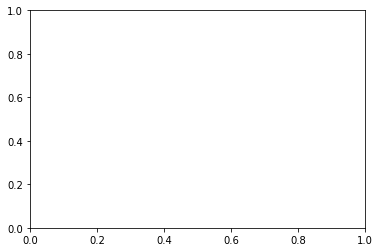

In [119]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement

num_iters = nn.batchsize * nn.epochs 
plt.plot(range(0,num_iters), cost_ite)
plt.xlabel('Iterations')
plt.ylabel('Training Error')
plt.title('Training Error vs Iterations')

plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [ ]:
# Plot the training error in every epoch
# TODO Implement

#print (len(nn.cost_)) 
plt.plot(range(1,nn.epochs+1), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs Epochs')
plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [ ]:
# Compute Training Accuracy
# TODO Implement

print('Training accuracy: %.2f%%' % (acc * 100))

# Compute Test Accuracy
# TODO Implement

print('Test accuracy: %.2f%%' % (acc * 100))

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Put the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.**

- Jane Doe, 123456
- Jane Doe, 123456
- Jane Doe, 123456

## Points: 0.0 of 30.0 points